# Building an Expected Goals (xG) Model for NHL Shots

Expected Goals (xG) is a statistic used in hockey analytics that measures the quality of a shot by estimating the probability it results in a goal. 
This project uses NHL shot data from the 2015–2023 seasons to build an xG model using machine learning.

The main goals of this project are:
- Analyze NHL shot data to identify key factors that influence scoring chances.  
- Build predictive models (Logistic Regression, XGBoost) to estimate the probability of a shot becoming a goal.  
- Compare predictions with actual results to evaluate player performance and shot quality.  
- Visualize results to make insights clear and actionable. 

## Loading and cleaning data

Importing the necessary packages for model building/evaluation

In [202]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss, confusion_matrix, classification_report
from sklearn.calibration import calibration_curve

import xgboost as xgb

import pandas as pd
import plotly.express as px
import matplotlib as plt
import numpy as np

Now I import the csv file that contains shot data from moneypuck.com. This is a very large file (contains over 1 million shots between 2015-2023), so it should take a while to load

In [46]:
shots_df = pd.read_csv("C:/Users/student/Downloads/shots_2015-2023.zip")

In [51]:
shots_df.head()

,shotID,homeTeamCode,awayTeamCode,season,isPlayoffGame,game_id,homeTeamWon,id,time,timeUntilNextEvent,...,xFroze,xRebound,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xShotWasOnGoal,isHomeTeam,shotWasOnGoal,teamCode,arenaAdjustedXCordABS
0,0,TBL,NSH,2023,0,20001,1,10,61,9.0,...,0.249174,0.035816,0.379310,0.277143,0.022744,0.751320,1.0,1.0,TBL,59.0
1,1,TBL,NSH,2023,0,20001,1,11,70,26.0,...,0.107945,0.051284,0.464358,0.298119,0.020588,0.589712,1.0,1.0,TBL,81.0
2,2,TBL,NSH,2023,0,20001,1,13,107,2.0,...,0.236193,0.030269,0.390417,0.301375,0.025620,0.785765,1.0,1.0,TBL,55.0
3,3,TBL,NSH,2023,0,20001,1,19,177,35.0,...,0.198635,0.033686,0.438052,0.291724,0.021107,0.724471,1.0,1.0,TBL,58.0
4,4,TBL,NSH,2023,0,20001,1,21,231,29.0,...,0.188582,0.027146,0.406288,0.349752,0.019523,0.727481,0.0,0.0,NSH,64.0


Each row in the dataset represents a single shot attempt.  
The outcome of the shot is recorded in the `goal`column:

- `1` → The shot resulted in a goal.  
- `0` → The shot did not result in a goal (saved, missed, or blocked).  

This binary outcome is the target variable in our model.  
Our goal is to predict the probability that a given shot (based on its features such as location, angle, shot type, etc.) will result in `goal = 1`.

In [6]:
shots_df['goal'] = shots_df['goal'].astype(int)
print(shots_df['goal'].value_counts())

0    937708
1     68795
Name: goal, dtype: int64


In order to clean the dataset, I drop rows where the core shot info (shot distance and shot angle) is missing. I also fill all the empty rows for categorical variables (shot type, event category and the position of the player) as `Unknown`

In [52]:
df = shots_df.dropna(subset=['shotDistance', 'shotAngle'])

categorical_cols = ['shotType', 'lastEventCategory', 'playerPositionThatDidEvent']
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")


## Feature Selection

Before building the xG model, it is important to explore the dataset to identify features that are most predictive of whether a shot will result in a goal.  

For training the xG model, I selected the following features:  

- `shotDistance`, `shotAngle` : capture shot location and geometry.  
- `timeSinceLastEvent` : context of how quickly the shot followed the last play.  
- `homeSkatersOnIce`, `awaySkatersOnIce` : represents manpower advantage (e.g., power plays).  
- `shotType` : differentiates between wrist shots, slap shots, rebounds, etc.  
- `lastEventCategory` : context of the play that directly preceded the shot.  
- `playerPositionThatDidEvent` : whether the shooter was a forward or defenseman.  
- `period` : situational context (early vs late game).  
- `shotRebound`, `shotRush` : captures high-danger situations.  
- `isHomeTeam` : possible home-ice advantage. 

All of these features will be `X` for the model, and the `y` is the target variable, which is `goal`.

By focusing on these features in the exploratory analysis, we can better understand the factors that drive scoring chances and select the most relevant predictors for training the xG model.

In [55]:
features = [
    'shotDistance', 'shotAngle', 'timeSinceLastEvent',
    'homeSkatersOnIce', 'awaySkatersOnIce',
    'shotType', 'lastEventCategory', 'playerPositionThatDidEvent',
    'period', 'shotRebound', 'shotRush', 'isHomeTeam'
]

X = df[features]
y = df['goal']

Since some of the features are categorical variables (like `shotType`, `lastEventCategory`, `playerPositionThatDidEvent`, and `period`), they cannot be directly used in a machine learning model because the model works with numerical inputs. To handle this, I apply one-hot encoding, which converts each category into a new binary column (`0` or `1`).

In [9]:
X = pd.get_dummies(X, columns=['shotType', 'lastEventCategory', 'playerPositionThatDidEvent', 'period'], drop_first=True)

## Model Building

For the other numerical columns, I have to make sure no feature dominates the model. To deal with this, I apply `StandardScaler`, which standardizes them to have mean `0` and standard deviation `1`.

In [10]:
num_cols = ['shotDistance', 'shotAngle', 'timeSinceLastEvent', 'homeSkatersOnIce', 'awaySkatersOnIce']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

The dataset is now split into training (80%) and testing (20%) sets using `train_test_split`.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

The first model I create is a simple logistic regression, which will serve as the baseline. It is interpretable and well-suited for binary classification (goal vs. no goal)

In order to deal with the natural imbalnce of the data (most shots don't end up as goals), the `class_weight` is set to `balanced`

In [12]:
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

Predictions:

The model outputs two things:

Predicted probabilities (`predict_proba`): likelihood that a shot becomes a goal.

Predicted labels (`predict`): whether the model classifies the shot as a goal `1` or not `0`.

In [13]:
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
y_pred = log_reg.predict(X_test)

auc = roc_auc_score(y_test, y_pred_proba)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"ROC-AUC Score: {auc:.3f}")
print(f"Brier Score: {brier:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

ROC-AUC Score: 0.718
Brier Score: 0.218
Confusion Matrix:
[[115955  71587]
 [  4029   9730]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.62      0.75    187542
           1       0.12      0.71      0.20     13759

    accuracy                           0.62    201301
   macro avg       0.54      0.66      0.48    201301
weighted avg       0.91      0.62      0.72    201301



## Evaluating the Model

Evaluation Metrics

ROC-AUC Score (0.718): Measures how well the model distinguishes goals vs. non-goals. A score closer to 1 is better.

Brier Score (0.218): Measures calibration (how close predicted probabilities are to actual outcomes). Lower is better.

Confusion Matrix & Classification Report: Provide more detail about precision, recall, and accuracy.

After fitting the Logistic Regression model, I inspect the learned coefficients for each feature.  
These values indicate both the direction and strength of each feature’s relationship with the probability that a shot becomes a goal.

- Sign (+/-):
  - Positive coefficient → increases the log-odds of a goal (higher predicted xG).
  - Negative coefficient → decreases the log-odds of a goal (lower predicted xG).

- Magnitude
  - Larger absolute values imply a stronger influence on the prediction.
  - Remember that coefficients are on the log-odds scale; comparisons are most meaningful relative to each other.

Below, are the 15 most positive and 15 most negative coefficients.  
This highlights which shot/context features the model associates with higher vs lower scoring likelihood.

Examples that align with hockey intuition:
- `shotRush`, `shotRebound`, and categories like `lastEventCategory_CHL` show positive effects: rushes/rebounds/slot chances tend to be dangerous.
- `shotDistance` and some late-period indicators (e.g., `period_6`) show negative effects: longer-distance shots and certain special situations tend to be less likely to score.

In [14]:
coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_reg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print(coeffs.head(15))
print(coeffs.tail(15))

                               Feature  Coefficient
16               lastEventCategory_CHL     2.389667
36  playerPositionThatDidEvent_Unknown     1.175297
21              lastEventCategory_GEND     0.924788
6                             shotRush     0.812261
12                    shotType_Unknown     0.759995
9                        shotType_SLAP     0.695882
5                          shotRebound     0.678821
43                            period_8     0.650487
10                       shotType_SNAP     0.627180
39                            period_4     0.511245
14                      shotType_WRIST     0.337566
30              lastEventCategory_STOP     0.327547
38                            period_3     0.280504
27              lastEventCategory_PENL     0.204859
8                        shotType_DEFL     0.186416
                         Feature  Coefficient
19       lastEventCategory_EISTR    -0.161896
31        lastEventCategory_TAKE    -0.216442
32  playerPositionThatDidEvent

### Building an XGBoost Model

After testing Logistic Regression, I also trained an XGBoost Classifier to capture more complex, non-linear relationships in the shot data.  

XGBoost (Extreme Gradient Boosting) is an ensemble learning method that builds many decision trees sequentially, where each new tree attempts to correct the errors of the previous ones. It is well-suited for tabular datasets like this one and often performs better than linear models because it can capture interactions between features.  

The model is then trained on the training dataset (`X_train`, `y_train`) and learns patterns that can better predict whether a shot results in a goal compared to a baseline Logistic Regression.  


In [15]:
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6, 
    subsample=0.8,     
    colsample_bytree=0.8,
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])
)

xgb_model.fit(X_train, y_train)

C:\Users\student\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Just like the logistic regression, I am going to evaluate the model and see how it performed.

In [16]:
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.1).astype(int) 

auc = roc_auc_score(y_test, y_pred_proba)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"ROC-AUC Score: {auc:.3f}")
print(f"Brier Score: {brier:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

ROC-AUC Score: 0.773
Brier Score: 0.192
Confusion Matrix:
[[ 17018 170524]
 [   110  13649]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.09      0.17    187542
           1       0.07      0.99      0.14     13759

    accuracy                           0.15    201301
   macro avg       0.53      0.54      0.15    201301
weighted avg       0.93      0.15      0.16    201301



### Comparing logistic regression and XGBoost

Logistic Regression: More balanced but weaker separation, with moderate performance in both classes.

XGBoost: Very strong at identifying goals (class 1) with high recall (0.99), but struggles with precision, leading to many false positives (predicting a goal when it wasn’t).

Overall: XGBoost achieves higher overall discrimination, but Logistic Regression provides easier interpretability.

The chart that scores the most important features when predicting a goal in the xgboost model.

`shotAngle` and `shotDistance` are the most important predictors of whether a shot results in a goal. They have the highest F-scores (5336 and 5321), meaning they were most frequently used in decision splits across the boosted trees.

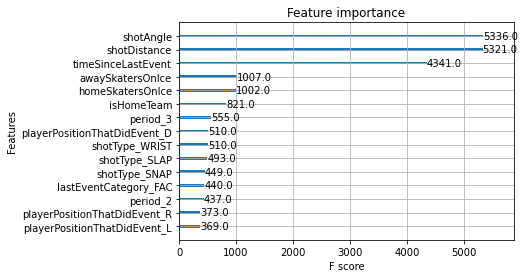

In [17]:
xgb.plot_importance(xgb_model, max_num_features=15)
plt.show()

### Calibration Curves

A calibration curve shows the probability of a shot being a goal directly. 

- The blue line shows the relationship between the predicted probabilities from the model and the actual observed frequency of goals. 
- The orange dashed line is the ideal calibration line, where predicted probabilities perfectly match observed frequencies.

The blue curve in the chart below is way below the ideal calibration line until the very high probailities. This shows that for most shots, the model is overestimating the chance of a goal.

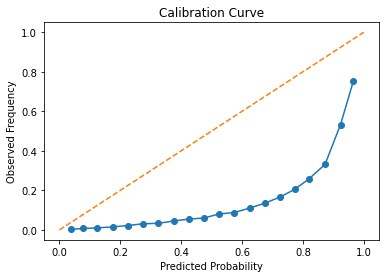

In [18]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=20)
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve")
plt.show()

In order to improve the line, I chose to do an isotonic regression. This method is very beneficial when there is a large amount of data as it prevents overfitting

In [19]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(xgb_model, cv=5, method="isotonic")
calibrated_model.fit(X_train, y_train)

y_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

C:\Users\student\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\student\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\student\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:46:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\student\anaconda3\lib\site-p

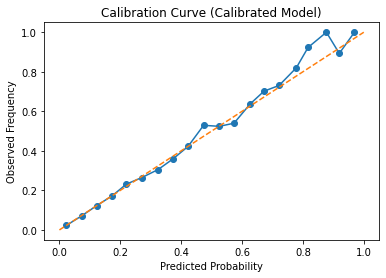

In [20]:
prob_true, prob_pred = calibration_curve(y_test, y_calibrated, n_bins=20)

plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve (Calibrated Model)")
plt.show()

After applying isotonic regression with `CalibratedClassifierCV`, the calibration curve improves significantly:  
- The blue curve closely follows the diagonal reference line (orange line), meaning predicted probabilities now match observed frequencies much more closely.  
- For example, when the model predicts a 0.7 probability of a goal, roughly 70% of those shots actually resulted in a goal.  
- This demonstrates that calibration corrected the bias in the raw XGBoost probabilities, making them well-calibrated and reliable.

## Player Evaluation

Now that the model is built, I am going to look at how it predicted the expected goals for each player. 

First I need to join the test dataframe with certain columns in the original dataframe (df) in order to get the names of the players that took each shot. 

In [101]:
idx_test = X_test.index

meta_cols = ["shooterPlayerId", "shooterName", "team", "game_id", "season"]

df.rename(columns=lambda c: c.strip(), inplace=True)

df_test = pd.DataFrame(index=idx_test)
df_test["goal"] = y_test
df_test["xG"]   = y_calibrated

df_test = df_test.join(df.loc[idx_test, meta_cols])

print(df_test.head())

        goal        xG  shooterPlayerId         shooterName  team  game_id  \
642492     0  0.063358        8478038.0         Devon Toews  HOME    21084   
55051      0  0.025341        8476931.0         Jake McCabe  HOME    20627   
273000     0  0.009711        8478399.0  Jonas Siegenthaler  HOME    20339   
276182     0  0.104524        8476934.0        Brock McGinn  AWAY    20376   
263672     0  0.101769        8473419.0       Brad Marchand  HOME    20224   

        season  
642492    2018  
55051     2023  
273000    2021  
276182    2021  
263672    2021  


Now I am going to group by each player to see how many expected goals the model predicted and the number of actual goals they have scored, along with the difference between the two.

Since I am only using the test data, the number of goals and expected goals will seem low (the test data contains only 20% of the entire dataset)

In [102]:
player_xg = (
    df_test.groupby(["shooterPlayerId", "shooterName"], dropna=False)
           .agg(total_shots=("xG", "count"),
                total_xG=("xG", "sum"),
                actual_goals=("goal", "sum"))
           .reset_index()
)
player_xg["goals_minus_xG"] = player_xg["actual_goals"] - player_xg["total_xG"]
player_xg.sort_values("goals_minus_xG", ascending=False).head(10)

,shooterPlayerId,shooterName,total_shots,total_xG,actual_goals,goals_minus_xG
699,8476453.0,Nikita Kucherov,654,48.706474,75,26.293526
364,8474564.0,Steven Stamkos,523,43.494830,67,23.505170
162,8471214.0,Alex Ovechkin,832,62.646743,85,22.353257
1212,8479318.0,Auston Matthews,712,62.651813,84,21.348187
976,8477934.0,Leon Draisaitl,593,59.186339,80,20.813661
1095,8478420.0,Mikko Rantanen,516,45.058290,65,19.941710
705,8476459.0,Mika Zibanejad,580,45.758358,65,19.241642
924,8477492.0,Nathan MacKinnon,825,58.906064,78,19.093936
274,8473512.0,Claude Giroux,500,33.725877,52,18.274123
519,8475692.0,Mats Zuccarello,409,31.482636,47,15.517364


As you can see, the players that have the highest difference in goals and expected goals are some of the best players in the world. This is because xG assumes an average skater vs. an average goalie, so players like Auston Matthews and Nikita Kucherov will finish well above their predicted value due to their elite shooting skill. 

In order to clean this dataset, I am only going to include players that have taken at least 100 shots. I'm also going to look at the shooting percentages by dividing the goals and xG by the number of shots

In [103]:
min_shots = 100
player_xg = player_xg[player_xg.total_shots >= min_shots].copy()

player_xg["goals_per_shot"] = player_xg.actual_goals / player_xg.total_shots
player_xg["xg_per_shot"]    = player_xg.total_xG / player_xg.total_shots
player_xg["finishing_plus_minus"] = player_xg.goals_minus_xG 

In [104]:
player_xg.sort_values("goals_minus_xG", ascending=False).head(15)

player_xg.sort_values("total_xG", ascending=False).head(15)

,shooterPlayerId,shooterName,total_shots,total_xG,actual_goals,goals_minus_xG,goals_per_shot,xg_per_shot,finishing_plus_minus
439,8475166.0,John Tavares,646,66.070978,69,2.929022,0.106811,0.102277,2.929022
1085,8478402.0,Connor McDavid,672,65.032495,77,11.967505,0.114583,0.096775,11.967505
1212,8479318.0,Auston Matthews,712,62.651813,84,21.348187,0.117978,0.087994,21.348187
162,8471214.0,Alex Ovechkin,832,62.646743,85,22.353257,0.102163,0.075297,22.353257
976,8477934.0,Leon Draisaitl,593,59.186339,80,20.813661,0.134907,0.099808,20.813661
997,8477956.0,David Pastrnak,768,58.925635,74,15.074365,0.096354,0.076726,15.074365
924,8477492.0,Nathan MacKinnon,825,58.906064,78,19.093936,0.094545,0.071401,19.093936
207,8471675.0,Sidney Crosby,619,57.246991,62,4.753009,0.100162,0.092483,4.753009
1099,8478427.0,Sebastian Aho,536,56.540369,52,-4.540369,0.097015,0.105486,-4.540369
975,8477933.0,Sam Reinhart,551,54.576428,63,8.423572,0.114338,0.099050,8.423572


A distribution of all points showing expected goals vs. actual goals. 

There are a few outliers around the 60-goal mark, but those are expected for the elite snipers in the league.

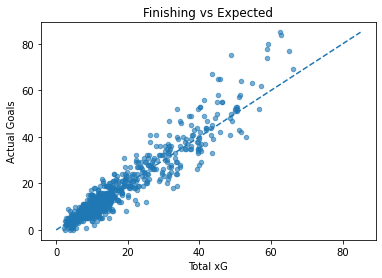

In [105]:
ax = player_xg.plot.scatter(x="total_xG", y="actual_goals", alpha=0.6)
lims = [0, max(player_xg[["total_xG","actual_goals"]].max())]
ax.plot(lims, lims, linestyle="--")  # y=x line
ax.set_xlabel("Total xG"); ax.set_ylabel("Actual Goals"); ax.set_title("Finishing vs Expected")
plt.show()

Since the dataset contains data from 2015-2023, I wanted group the data by season and player to see how the model has performed across each season.

In [111]:
per_season = (
    df_test.groupby(["season","shooterPlayerId","shooterName"])
           .agg(total_shots=("xG","count"),
                total_xG=("xG","sum"),
                actual_goals=("goal","sum"))
           .reset_index()
)
per_season["goals_minus_xG"] = per_season.actual_goals - per_season.total_xG
per_season["Shot%"] = per_season.actual_goals / per_season.total_shots
per_season["xShot%"] = per_season.total_xG / per_season.total_shots
per_season

,season,shooterPlayerId,shooterName,total_shots,total_xG,actual_goals,goals_minus_xG,Shot%,xShot%
0,2015,8448208.0,Jaromir Jagr,40,4.126122,6,1.873878,0.150,0.103153
1,2015,8460542.0,Patrik Elias,6,0.855706,0,-0.855706,0.000,0.142618
2,2015,8462038.0,Shane Doan,56,4.727923,7,2.272077,0.125,0.084427
3,2015,8462042.0,Jarome Iginla,48,4.184557,6,1.815443,0.125,0.087178
4,2015,8464977.0,Dainius Zubrus,14,1.008121,0,-1.008121,0.000,0.072009
...,...,...,...,...,...,...,...,...,...
7643,2023,8484304.0,Uvis Balinskis,4,0.224000,1,0.776000,0.250,0.056000
7644,2023,8484314.0,Jiri Smejkal,5,0.253191,0,-0.253191,0.000,0.050638
7645,2023,8484321.0,Nikolas Matinpalo,1,0.012098,0,-0.012098,0.000,0.012098
7646,2023,8484325.0,Waltteri Merela,4,0.344597,0,-0.344597,0.000,0.086149


First, I want to look at the top individual seasons the model had. 

In [123]:
per_season.sort_values("total_xG", ascending=False).head(15)

,season,shooterPlayerId,shooterName,total_shots,total_xG,actual_goals,goals_minus_xG,Shot%,xShot%
7089,2023,8477933.0,Sam Reinhart,118,12.751653,16,3.248347,0.135593,0.108065
6906,2023,8475786.0,Zach Hyman,95,11.652453,14,2.347547,0.147368,0.122657
158,2015,8471214.0,Alex Ovechkin,139,11.639597,16,4.360403,0.115108,0.083738
7224,2023,8479318.0,Auston Matthews,109,11.297213,12,0.702787,0.110092,0.103644
6321,2022,8478402.0,Connor McDavid,110,10.937326,21,10.062674,0.190909,0.099430
5555,2021,8479318.0,Auston Matthews,131,10.675064,15,4.324936,0.114504,0.081489
5466,2021,8478402.0,Connor McDavid,103,10.613999,10,-0.613999,0.097087,0.103049
7221,2023,8479314.0,Matthew Tkachuk,107,10.317357,9,-1.317357,0.084112,0.096424
6576,2022,8480801.0,Brady Tkachuk,105,10.233456,11,0.766544,0.104762,0.097461
7106,2023,8477956.0,David Pastrnak,118,10.054508,10,-0.054508,0.084746,0.085208


It had Sam Reinhart's 2023 season as the top-scoring season. Out of 118 total shots, Reinhart generated 12.75 xG while scoring 16 goals. Reinhart scored 42 goals in 2023, which was the 12th highest in the league in that span. He also had the 8th highest shooting percentage in the entire NHL in that span, which is why the difference between his `actual_goals` and `total_xG` is relatively high.

In [129]:
per_season['abs_diff'] = per_season['goals_minus_xG'].abs()
top_15 = per_season.sort_values("abs_diff", ascending=False).head(15)
top_15["Shot%"] = top_15.actual_goals / top_15.total_shots
top_15["xShot%"] = top_15.total_xG / top_15.total_shots
top_15

,season,shooterPlayerId,shooterName,total_shots,total_xG,actual_goals,goals_minus_xG,Shot%,xShot%,abs_diff
6321,2022,8478402.0,Connor McDavid,110,10.937326,21,10.062674,0.190909,0.099430,10.062674
2861,2018,8476453.0,Nikita Kucherov,90,6.368691,16,9.631309,0.177778,0.070763,9.631309
6284,2022,8478010.0,Brayden Point,81,9.833970,18,8.166030,0.222222,0.121407,8.166030
6330,2022,8478420.0,Mikko Rantanen,100,10.009890,18,7.990110,0.180000,0.100099,7.990110
5113,2021,8475169.0,Evander Kane,64,7.037254,15,7.962746,0.234375,0.109957,7.962746
3078,2018,8477956.0,David Pastrnak,86,6.279680,14,7.720320,0.162791,0.073020,7.720320
6255,2022,8477934.0,Leon Draisaitl,78,7.303627,15,7.696373,0.192308,0.093636,7.696373
6271,2022,8477955.0,Jared McCann,61,4.316013,12,7.683987,0.196721,0.070754,7.683987
2270,2017,8477492.0,Nathan MacKinnon,96,6.351727,14,7.648273,0.145833,0.066164,7.648273
978,2016,8471698.0,T.J. Oshie,48,4.408430,12,7.591570,0.250000,0.091842,7.591570


I want to visualize the players that caused the highest discrepancy between goals and xG. Most of the players on this chart are ones that had elite seasons like McDavid in 2022 and Leon Draisaitl in 2019 and 2022. 

Looking at the shooting percentage (`Shot%`) and expected shooting percentage (`xShot%`) for each player, we can see there is a large difference bewtween a majority of these values. Some of these players, like TJ Oshie in 2016 and Evander Kane in 2021, had very high shooting percentages at well over 20%. 

There are many factors that cause a high shooting percentage that the model cannot account for, like traffic in front of goal and the puck movement leading up to the goal. 

In [133]:
top_15["player_season"] = top_15["shooterName"] + " (" + top_15["season"].astype(str) + ")"
top_15["xShot%"] = top_15.total_xG / top_15.total_shots
top_15 = top_15.round(4)
fig = px.bar(top_15, x='player_season', y='goals_minus_xG', color="Shot%")
fig.show()

### Shot Map Visualization

To better understand where shots are being taken and how dangerous they are, I created a shot map based on the shot location. The original dataset has the X and Y coordinate of every shot recorded, adjusted to the arena it was in.

I used https://thecommutesports.com/2022/08/06/creating-nhl-shot-maps-with-python/ as a reference for creating some of this code. 

Plotting every single shot as a scatterplot quickly became too cluttered due to the size of the dataset. To address this, I explored a hexbin aggregation.

Instead of plotting individual shots, the rink is divided into small hexagonal bins. Within each bin, the average expected goals (xG) value of all shots is calculated. This allows for a smoother view of which areas of the ice produce higher-quality chances, while filtering out random noise from individual low-probability shots.

Additionally, I limited the scope of the shot maps by:
- Focusing only on the offensive half of the rink.  
- Filtering out empty-net shots, which are not modeled in xG.  

By using these methods, the visualization provides a clearer and more interpretable picture of where dangerous chances are generated. Instead of a noisy cloud of points, the shot maps highlight meaningful patterns in scoring opportunities.

In [200]:
df_test['shotOnEmptyNet'].value_counts()

0    200099
1      1202
Name: shotOnEmptyNet, dtype: int64

In [174]:
df_no_empty_net = df_test[df_test['shotOnEmptyNet'] == 0]
print(df_no_empty_net['shotOnEmptyNet'].value_counts())

0    200099
Name: shotOnEmptyNet, dtype: int64


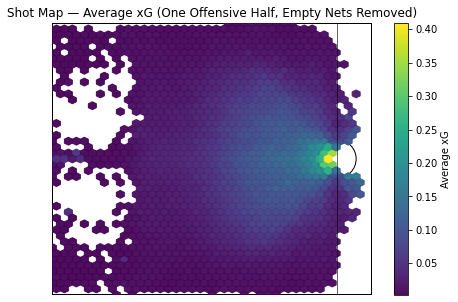

In [189]:
df_plot = df_no_empty_net.copy()

if "arenaAdjustedXCordABS" in df_plot.columns:
    df_plot["x_abs"] = pd.to_numeric(df_plot["arenaAdjustedXCordABS"], errors="coerce")
elif "arenaAdjustedXCord" in df_plot.columns:
    df_plot["x_abs"] = pd.to_numeric(df_plot["arenaAdjustedXCord"], errors="coerce").abs()
else:
    raise KeyError("Need arenaAdjustedXCordABS or arenaAdjustedXCord in the dataframe.")

y_col = "arenaAdjustedYCord" if "arenaAdjustedYCord" in df_plot.columns else \
        ("arenaAdjustedYCordABS" if "arenaAdjustedYCordABS" in df_plot.columns else None)
if y_col is None:
    raise KeyError("Need arenaAdjustedYCord (or arenaAdjustedYCordAbs) in the dataframe.")
df_plot[y_col] = pd.to_numeric(df_plot[y_col], errors="coerce")

df_plot = df_plot.query("0 <= x_abs <= 100")
df_plot = df_plot[(df_plot[y_col] >= -42.5) & (df_plot[y_col] <= 42.5)]
df_plot = df_plot.dropna(subset=["x_abs", y_col, "xG"])

def draw_half_rink(ax):
    ax.set_xlim(0, 100); ax.set_ylim(-42.5, 42.5)
    ax.add_patch(plt.Rectangle((0, -42.5), 100, 85, fill=False, linewidth=2))
    ax.axvline(89, color="black", linewidth=1, alpha=0.6)
    ax.add_patch(plt.Circle((89, 0), 6, fill=False, linewidth=1))
    ax.set_aspect("equal"); ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(False)

fig, ax = plt.subplots(figsize=(8,5))
draw_half_rink(ax)

hb = ax.hexbin(
    df_plot["x_abs"], df_plot[y_col],
    C=df_plot["xG"], reduce_C_function=np.mean,
    gridsize=40, extent=(0,100,-42.5,42.5),
    mincnt=10, alpha=0.95
)
cb = plt.colorbar(hb, ax=ax); cb.set_label("Average xG")

ax.set_title("Shot Map — Average xG (One Offensive Half, Empty Nets Removed)")
plt.show()

The bright yellow cluster right in front of the net (aka the “slot”) suggests these shots have very high xG, meaning they are much more likely to result in goals. Areas near the blue line or far corners show very low xG values.

## Conclusion & Results

In this project, I developed an expected goals (xG) model to estimate the probability that a given shot results in a goal. The analysis covered the full pipeline from data preparation to model evaluation and player-level insights.

### Model Development
- Baseline Model – Logistic Regression: I first trained a logistic regression model, which served as a transparent baseline. Logistic regression provided interpretable coefficients but had limitations in capturing complex feature interactions.  
- Advanced Model – XGBoost: I then trained an XGBoost classifier, which is well-suited for structured sports data. This model improved predictive accuracy by capturing nonlinear relationships and feature interactions that logistic regression could not.  
### Model Evaluation
- Both models were evaluated on held-out test data using metrics such as log loss, Brier score, and ROC AUC.  
- XGBoost consistently outperformed logistic regression, showing better calibration of predicted probabilities and stronger discriminative ability between goals and non-goals.  
- The calibrated probabilities from the best-performing model were used as our final xG values.

### Results & Insights
- Player Evaluation: By aggregating xG and goals at the player-season level, I measured finishing ability through `goals_minus_xG`. This highlights which players consistently overperform (elite finishers) or underperform (struggling finishers) relative to expectation.  
- Seasonal Analysis: Breaking down results by season revealed standout years where players significantly exceeded their expected scoring output.  
- Reliability Filters: To reduce noise, I restricted results to players with at least 100 shots in their career, making sure there would be less outliers.
- Key Findings: 
  - Elite scorers such as Connor McDavid, Leon Draisaitl, and Auston Matthews frequently outperformed xG, reflecting their high finishing talent and shooting percentage.  
  - High-volume shooters like Alex Ovechkin generated the largest xG totals, showing his ability to get shots through from any spot on the ice.  
  - The xG model provides a more nuanced measure of performance than raw goals, distinguishing sustainable scoring from hot streaks or luck.